# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 2 - Introduction à la régression linéaire

Ce calepin Jupyter accompage le chapitre 2 des notes de cours.

Chargeons d'abord les librairies nécessaires.

In [1]:
using CSV, DataFrames             # Pour charger et organiser les données
using Gadfly                      # Pour générer des graphiques
using Distributions               # Pour utiliser les distributions statistiques
using LinearAlgebra               # Pour utiliser les fonctions d'algèbre linéaire
using Combinatorics               # Pour énumérer toutes les possibilités

Si les librairies ne sont pas installées, excécutez le code suivant :

```julia
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"])
```

# Chargement des données

In [2]:
# Chargement du fichier de données 

filename = joinpath(dirname(@__FILE__), "Data", "FF_emissions.csv")

data = CSV.read(filename, DataFrame)

# Les colonnes sont renommées avec des noms plus courts
rename!(data, :FF_emissions => :FF)
rename!(data, :LUC_emissions => :LUC)
rename!(data, :ocean_sink => :Ocean)
rename!(data, :land_sink => :Land)
rename!(data, :T_anomaly => :T)

# Les océans et les strates végétales absorbent le carbone
data[!,:Ocean] = -data[:,:Ocean]
data[!,:Land] = -data[:,:Land]

# Affichage des 5 premières lignes du tableau de données
first(data,5)

Row,Year,FF,LUC,Ocean,Land,T
,Int64,Float64,Float64,Float64,Float64,Float64
1,1959,2.45,1.47,-0.92,-0.97,0.08
2,1960,2.57,1.46,-0.93,-1.59,0.08
3,1961,2.58,1.53,-0.8,-1.65,0.15
4,1962,2.69,1.52,-0.87,-2.15,0.06
5,1963,2.83,1.53,-1.03,-2.12,0.05


In [3]:
# Extraction des données du DataFrame
# Utile pour écrire simplement les calculs matriciels

x₁ = data[:,:FF]     # Vecteur de la variable explicative 1
x₂ = data[:,:LUC]    # Vecteur de la variable explicative 2
x₃ = data[:,:Ocean]  # Vecteur de la variable explicative 3
x₄ = data[:,:Land]   # Vecteur de la variable explicative 4
y = data[:,:T]       # Variable d'intérêt
n = length(y)        # Nombre d'observations

57

# Analyse exploratoire

Étape permettant d'obtenir une vision globale du jeu de données. Elle peut également permettre de découvrir des dépendances entre les variables. L'analyse exploratoire peut s'affectuer à l'aide de graphiques et de statistiques simples.

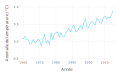

In [4]:
# Traçage de l'anomalie de température en fonction des années

Gadfly.set_default_plot_size(12cm, 8cm)
fig1 = plot(data, x=:Year, y=:T, Geom.line,
    Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=1960:10:2015),
    Guide.xlabel("Année"),
    Guide.ylabel("Anomalie de température (°C)")) 

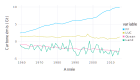

In [5]:
# Traçage des composantes du cycle du carbone en fonction des années

Gadfly.set_default_plot_size(14cm, 8cm)
fig2 = plot(stack(data, [:FF, :LUC, :Ocean, :Land]), x=:Year, y=:value, color=:variable, Geom.line,
    Coord.Cartesian(xmin=1959, xmax=2015), Guide.xticks(ticks=1960:10:2015),
    Guide.xlabel("Année"),
    Guide.ylabel("Carbone émis (Gt)"))

# 2.1 Modèle de régression linéaire simple

Pour commencer, on utilise seulement les émissions par combustion de combustibles fossibles 
comme variable explicative.

### Estimation des paramètres du modèle de régression linéaire simple

In [6]:
# Calcul des statistiques utiles
x̄ = mean(x₁)
ȳ = mean(y)

# Estimation des paramètres
β̂₁ = sum( (x₁[i] - x̄)*(y[i] - ȳ) for i=1:n) / sum( (x₁[i] - x̄)^2 for i=1:n )

β̂₀ = ȳ - β̂₁*x̄

println("L'ordonnée à l'origine estimée est β̂₀=", β̂₀)
println("La pente de la droite de régression estimée est β̂₁=", β̂₁)


L'ordonnée à l'origine estimée est β̂₀=-0.3574329447398635
La pente de la droite de régression estimée est β̂₁=0.11316846326977269


### Affichage de la droite de régression

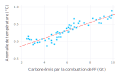

In [7]:
Gadfly.set_default_plot_size(12cm, 8cm)
plot(data, x=:FF, y=:T, Geom.point, 
    intercept = [β̂₀], slope = [β̂₁], Geom.abline(color="red", style=:dash),
    Coord.cartesian(xmin=2, xmax=10),
    Guide.xlabel("Carbone émis par la combustion de FF (Gt)"),
    Guide.ylabel("Anomalie de température (°C)"))

# 2.2 Modèle de régression linéaire multiple

Dans cette section, toutes les variables explicatives sont utilisées pour expliquer les anomalies de température.

### 2.2.2 Estimation des paramètres du modèle de régression multiple

Estimation des paramètres à l'aide de la méthode des moindres carrés.

In [8]:
# Construction de la matrice de structure (Notez la colonnes de 1)
X = hcat(ones(n),x₁,x₂,x₃,x₄)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'y

println("Les estimations des coefficient de régression sont β̂ = ", β̂)

Les estimations des coefficient de régression sont β̂ = [-0.5973852647803128, 0.171106940899803, 0.18789865318566154, 0.13484499901704466, 0.04406430037649416]


### 2.2.3 Prévision de l'anomalie de température

Supposons que l'on veut savoir qu'elle sera l'anomalie de température si on émet les quantités suivantes :

 - 10 Gt de C par FF
 - 1.5 Gt de C par LUC
 - -1 Gt de C par Ocean
 - -1 Gt de C par Land

In [9]:
# Définition du vecteur des variables explicatives pour lesquelles on veut estimer la variable d'intérêt
x₀ = [1 10 1.5 -1 -1]

# Estimation de l'anomalie de température
Ŷ₀ = x₀*β̂

println("L'anomalie de température estimée correspondante est de ",Ŷ₀)

L'anomalie de température estimée correspondante est de [1.2166228246026705]


# 2.3 Indice de qualité du modèle de régression

## 2.3.1 Décomposition de la variabilité

In [10]:
ȳ = mean(y)
ŷ = X*β̂

e = y-ŷ

SST = sum( (y .- ȳ).^2 )
SSR = sum( (ŷ .- ȳ).^2 )
SSE = sum(e.^2)

println("La variabilité totale est de ", SST)
println("La variabilité expliquée est de ", SSR)
println("La variabilité résiduelle est de ", SSE)

La variabilité totale est de 3.8466140350877196
La variabilité expliquée est de 3.3297385534036
La variabilité résiduelle est de 0.5168754816840505


On peut vérifier que $e^\top ŷ = 0$ et $e^\top 1 = 0$.

In [11]:
println("e'ŷ = ",e'*ŷ) 
println("e'1 = ",e'*ones(n)) 

e'ŷ = 2.581268532253489e-14
e'1 = -2.883804306463844e-14


## 2.3.2 Coefficient de détermination

In [12]:
R² = SSR/SST
println("Le coefficient de détermination est de ", R²)

Le coefficient de détermination est de 0.8656284521999534


# 2.5 Propriétés des estimateurs

## 2.5.2 Estimation de la variance de l'erreur

In [13]:
# Nb de variables explicatives
p = size(X,2)-1 # la colonne de 1 ne constitue pas une variable explicative

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )

println("σ̂² = $σ̂²")

σ̂² = 0.009939913109308664


## 2.5.4 Estimation de la matrice de covariance des estimateurs 

In [14]:
V = σ̂² * inv(X'X)

5×5 Matrix{Float64}:
  0.0157977   -0.00141133   -0.00836672   -0.00202683   2.12379e-5
 -0.00141133   0.000706904   0.00129956    0.0022148    0.000112682
 -0.00836672   0.00129956    0.00557083    0.00334809   0.000139165
 -0.00202683   0.0022148     0.00334809    0.00781481   0.000235994
  2.12379e-5   0.000112682   0.000139165   0.000235994  0.000197533

# 2.6 Tests d'hypothèses et intervalles de confiance

## 2.6.1 Test sur l'importance de la régression

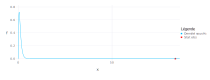

In [15]:
# Calcul de la statistique observée du test
F₀ = SSR/SSE * (n-p-1)/p

xx = 0:.1:100
pd = FDist(p, n-p-1) 
f = pdf.(pd,xx)

density= layer(x=xx, y=f, Geom.line, Theme(default_color="deepskyblue"))
statObs = layer(x=[F₀], y=[0], Geom.point, Theme(default_color="red") )

Gadfly.set_default_plot_size(21cm, 8cm)
plot(density, statObs,
    Guide.manual_color_key("Légende", ["Densité sous H₀", "Stat obs"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=0,xmax=85), Guide.xlabel("x"), Guide.ylabel("f"))

In [16]:
# Première façon de tester l'importance de la régression : comparaison avec le seuil critique

α = 0.05
point_critique = quantile(pd,1-α)
if F₀ > point_critique
    println("La régression est significative au seuil de $α car F₀ > point critique.
        On a en effet que F₀ = $F₀ > $point_critique)")
else
    println("La régression n'est pas significative au seuil de $α car F₀ < point critique.
        On a en effet que F₀ = $F₀ < $point_critique)")
end

La régression est significative au seuil de 0.05 car F₀ > point critique.
        On a en effet que F₀ = 83.74667154497865 > 2.549762971720928)


In [17]:
# Deuxième façon de tester l'importance de la régression : calcul de la valeur-p

α = 0.05
# calcul de la probabilité d'observer une statistique plus extrême que celle obtenue
seuil_observe = ccdf(pd,F₀) # la fonction ccdf correspond à 1-cdf()
if seuil_observe < α
    println("La régression est significative au seuil de $α car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = $seuil_observe < $α")
else
    println("La régression n'est pas significative au seuil de $α car le seuil observé du test est plus grand que α.
        On a en effet que seuil observé = $seuil_observe > $α")
end

La régression est significative au seuil de 0.05 car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = 5.095365269186361e-22 < 0.05


## 2.6.2 Intervalles de confiance sur les coefficients de régression

In [18]:
# calcul du quantile de la loi de Student
tₐ = quantile(TDist(n-p-1),.975)

# Affichage des intervalles de confiance
coeff_names = ["β₀", "β₁", "β₂", "β₃", "β₄"]
for j=0:p
    se = tₐ*sqrt(V[j+1,j+1])
   println("L'intervalle de confiance de niveau 95% pour $(coeff_names[j+1]) est [$(β̂[j+1] - se) , $(β̂[j+1] + se)]")
end

L'intervalle de confiance de niveau 95% pour β₀ est [-0.8495986036048429 , -0.3451719259557829]
L'intervalle de confiance de niveau 95% pour β₁ est [0.11775487838253726 , 0.22445900341706873]
L'intervalle de confiance de niveau 95% pour β₂ est [0.038126612603551435 , 0.33767069376777165]
L'intervalle de confiance de niveau 95% pour β₃ est [-0.04254537562047109 , 0.31223537365456044]
L'intervalle de confiance de niveau 95% pour β₄ est [0.01586159986108074 , 0.07226700089190759]


## 2.6.3 Intervalle de confiance sur une prédiction

Reprenons la prévision de la section 2.2.3. Calculons maintenons un intervalle de confiance de niveau 95 % pour cette prévision.

In [19]:
# Calcul de la marge d'erreur
se = quantile(TDist(n-p-1),.975)*sqrt( σ̂²*(1 .+x₀/(X'X)*x₀' )

println("L'intervalle de confiance de Ŷ₀ est [$(Ŷ₀[1] - se[1]) , $(Ŷ₀[1] + se[1])]")

LoadError: syntax: missing comma or ) in argument list

# 2.7 Validation des hypothèses de la régression linéaire

Analyse visuelle des résidus

In [20]:
function henryplot(y::Vector{<:Real})

    n = length(y)
    ysorted = sort(y)

    p = ( collect(1:n) .- .5 ) /n

    fd = fit(Normal,y)

    q = quantile.(fd,p)

    plot(x=ysorted, y=q, Geom.point,
    Guide.xlabel("Empirical quantiles"), Guide.ylabel("Estimated quantiles"),
    Theme(discrete_highlight_color=c->nothing),
    Geom.abline(color="red"))


end

henryplot (generic function with 1 method)

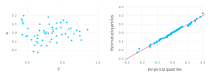

In [21]:
# Stockage des variables dans un DataFrame pour un affichage plus facile
df = DataFrame(Ŷ = ŷ, e = e)

Gadfly.set_default_plot_size(21cm, 8cm)
f1 = plot(df, x = :Ŷ, y = :e, Geom.point, Coord.Cartesian(xmin=-.1,xmax=1,ymin=-.3,ymax=.3))
f2 = henryplot(e)

hstack([f1, f2])


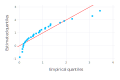

In [22]:
# Exemple de droite de Henry lorsque la distribution n'est pas normale


Gadfly.set_default_plot_size(12cm, 8cm)
henryplot(rand(Gamma(1,1),30))

# 2.9 Multicolinéarité

Vérification de la multicolinéarité avec le VIF.

In [23]:
variables = names(data)[2:5]

df = DataFrame(Variable = String[], VIF = Float64[])

for variable in combinations(variables,1)
    
#     println(variable[])
   
    y = data[:, variable[] ]
    ȳ = mean(y)
    
    X = hcat(ones(n), Matrix(data[:, setdiff(variables, variable)]) )
    
    β̂ = X\y
    ŷ = X*β̂

    e = y-ŷ

    SSE = e'*e
    SST = sum( (y .- ȳ).^2 )
    
    R² = 1 - SSE/SST
    
    VIF = 1/(1-R²)
    
    push!(df, [variable[], VIF])
    
end

df


Row,Variable,VIF
,String,Float64
1,FF,17.6985
2,LUC,2.30358
3,Ocean,12.7586
4,Land,1.28749


# 2.10 Sélection des variables explicatives

Dans cette section, on parcourt tous les modèles possibles. Il y en a 16 (en fait 15 si on exclut la possibilité où aucune des variables explicatives n'est sélectionnée). On calcule le coefficient de détermination ajusté de chacun de ces modèles pour déterminer le meilleur.

On constatera que le meilleur modèle est celui utilisant les 4 variables explicatives.

In [24]:

y = data[:, :T]
ȳ = mean(y)
SST = sum( (y .- ȳ).^2 )


variables = names(data)[2:5]

df = DataFrame(Variable = Vector{String}[], R² = Float64[])

for variable in combinations(variables)
    
    p = length(variable)
    
    X = hcat(ones(n), Matrix(data[:, variable]))
    
    
    β̂ = X\y
    ŷ = X*β̂

    e = y-ŷ

    SSE = e'*e

    R²aj =  1 - SSE/SST * (n-1)/(n-p-1)
    
    push!(df, [variable, R²aj])
#     println(variable)
    
end

sort(df, :R², rev=true)

Row,Variable,R²
,Array…,Float64
1,"[""FF"", ""LUC"", ""Ocean"", ""Land""]",0.855292
2,"[""FF"", ""LUC"", ""Land""]",0.85167
3,"[""FF"", ""Land""]",0.843446
4,"[""FF"", ""Ocean"", ""Land""]",0.840719
5,"[""FF"", ""LUC""]",0.831907
6,"[""FF"", ""LUC"", ""Ocean""]",0.831185
7,"[""FF""]",0.825458
8,"[""FF"", ""Ocean""]",0.822264
9,"[""LUC"", ""Ocean""]",0.745458


## On peut reproduire les résultats avec la librairie GLM

In [25]:
using Pkg
Pkg.add("GLM")

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [26]:
using GLM

lm(@formula(T ~ FF + LUC + Ocean + Land), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T ~ 1 + FF + LUC + Ocean + Land

Coefficients:
───────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -0.597385    0.125689   -4.75    <1e-04  -0.849599   -0.345172
FF            0.171107    0.0265877   6.44    <1e-07   0.117755    0.224459
LUC           0.187899    0.074638    2.52    0.0149   0.0381266   0.337671
Ocean         0.134845    0.0884014   1.53    0.1332  -0.0425454   0.312235
Land          0.0440643   0.0140546   3.14    0.0028   0.0158616   0.072267
───────────────────────────────────────────────────────────────────────────

In [27]:
using GLM

lm(@formula(T ~ FF), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T ~ 1 + FF

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -0.357433   0.0433576  -8.24    <1e-10  -0.444323   -0.270542
FF            0.113168   0.0069409  16.30    <1e-21   0.0992586   0.127078
──────────────────────────────────────────────────────────────────────────

In [28]:
# Construction de la matrice de structure (Notez la colonnes de 1)
X = hcat(ones(n),x₁)

# Estimation des paramètres du modèle de régression
β̂ = (X'X)\X'y

2-element Vector{Float64}:
 -0.35743294473986004
  0.11316846326977213

In [29]:
e = y - X*β̂

SSE = sum(e.^2)

# Nb de variables explicatives
p = size(X,2)-1 # la colonne de 1 ne constitue pas une variable explicative

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )

V = inv(X'X)

sqrt(σ̂²*V[2,2])

0.006940903374062097

In [30]:
t = β̂[2]/sqrt(σ̂²*V[2,2])

16.304572642903885

In [31]:
T = TDist(n-p-1)

TDist{Float64}(ν=55.0)

In [32]:
2*ccdf(T, t)

1.0142150090925481e-22

In [33]:
# zone critique
quantile(T, .975)

2.004044783289145

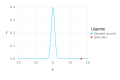

In [34]:

density = layer(x -> pdf(T, x), -20, 20)
statObs = layer(x=[t], y=[0], Geom.point, Theme(default_color="red") )

Gadfly.set_default_plot_size(12cm, 8cm)
plot(density, statObs,
    Guide.manual_color_key("Légende", ["Densité sous H₀", "Stat obs"], ["deepskyblue","red"]),
    Coord.Cartesian(xmin=-20,xmax=20), Guide.xlabel("x"), Guide.ylabel("f"))


In [35]:
β̂[2] + quantile(T, 0.975)*sqrt(σ̂²*V[2,2])

0.1270783444678753

In [36]:
temperatures = [280, 284, 292, 295, 298, 305, 308, 315]
viscosity = [770, 800, 840, 810, 735, 640, 590, 560]

8-element Vector{Int64}:
 770
 800
 840
 810
 735
 640
 590
 560

In [37]:
df = DataFrame(Temperature = temperatures, Viscosity = viscosity)

Row,Temperature,Viscosity
,Int64,Int64
1,280,770
2,284,800
3,292,840
4,295,810
5,298,735
6,305,640
7,308,590
8,315,560


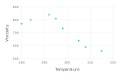

In [38]:
plot(df, x=:Temperature, y=:Viscosity, Geom.point)

In [39]:
n = nrow(df)

8

In [40]:
X = hcat(ones(n), df.Temperature)

8×2 Matrix{Float64}:
 1.0  280.0
 1.0  284.0
 1.0  292.0
 1.0  295.0
 1.0  298.0
 1.0  305.0
 1.0  308.0
 1.0  315.0

In [41]:
X = hcat(ones(n), df.Temperature, df.Temperature.^2)

8×3 Matrix{Float64}:
 1.0  280.0  78400.0
 1.0  284.0  80656.0
 1.0  292.0  85264.0
 1.0  295.0  87025.0
 1.0  298.0  88804.0
 1.0  305.0  93025.0
 1.0  308.0  94864.0
 1.0  315.0  99225.0

In [42]:
function polynomial_structure_matrix(x::Vector{<:Real}, order::Int)
   
    n = length(x)
    
    X = ones(n)
    
    for i in 1:order
       X = hcat(X, x.^i)
    end
    
    return X
    
end

polynomial_structure_matrix (generic function with 1 method)

In [43]:
X = polynomial_structure_matrix(df.Temperature, 7)

8×8 Matrix{Float64}:
 1.0  280.0  78400.0  2.1952e7   …  1.72104e12  4.8189e14   1.34929e17
 1.0  284.0  80656.0  2.29063e7     1.84753e12  5.24699e14  1.49014e17
 1.0  292.0  85264.0  2.48971e7     2.12283e12  6.19865e14  1.81001e17
 1.0  295.0  87025.0  2.56724e7     2.23414e12  6.59071e14  1.94426e17
 1.0  298.0  88804.0  2.64636e7     2.35007e12  7.00322e14  2.08696e17
 1.0  305.0  93025.0  2.83726e7  …  2.63936e12  8.05006e14  2.45527e17
 1.0  308.0  94864.0  2.92181e7     2.77175e12  8.53698e14  2.62939e17
 1.0  315.0  99225.0  3.12559e7     3.10136e12  9.7693e14   3.07733e17

In [44]:
β̂ = X\df.Viscosity

8-element Vector{Float64}:
    -1.1053326144645625e12
     2.6108768356504856e10
    -2.6423052841378227e8
     1.4852074101971856e6
 -5007.51804382788
    10.127198003112584
    -0.011375323833917511
     5.474465809261215e-6

In [45]:
ŷ = X*β̂

8-element Vector{Float64}:
 770.00390625
 800.00390625
 840.0
 810.00390625
 735.00390625
 640.0078125
 590.0
 560.0

In [46]:
function polynome(β̂::Vector{<:Real}, x::Real)
   
    ŷ = 0.0
    
    for i in eachindex(β̂)
        
        ŷ += β̂[i]*x.^(i-1)
        
    end
    
    return ŷ
    
end

polynome (generic function with 1 method)

In [47]:
polynome(β̂, 280)

770.0018310546875

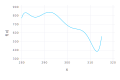

In [48]:
plot(x-> polynome(β̂, x), 280, 315)